In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf
from date_processing import *

pysqldf = lambda q: sqldf(q, globals())

pd.read_csv(
    'history/GSPC_original.csv',
    sep='\t').to_csv('history/GSPC.csv')

In [2]:
ETF = 'NDX'
ETF_3x = 'TQQQ'

etf_csv_file = 'history/{}.csv'.format(ETF)
etf_3x_csv = 'history/{}.csv'.format(ETF_3x)
simulation_result_xlsx = 'results/{}_simulation.xlsx'.format(ETF_3x)

leverage_ratio = 3

ETF = 'GSPC'
ETF_3x = 'SPXL'

In [3]:
qqq  = pd.read_csv(
    etf_csv_file,
    )

qqq['Date'] = qqq['Date'].apply(date_normalize)
qqq['Close'] = qqq['Close'].apply(str_to_float)

qqq = pysqldf(u"""
    select *
    from qqq
    order by Date asc
    """)

qqq['id'] = qqq.index

In [4]:
qqq = pysqldf(u"""
    select qqq.*, 
    pre_day.Date as pre_Date,
    pre_day.Close as pre_Close,
    (qqq.Close - pre_day.Close)/pre_day.Close AS Percent    
    from qqq 
    left join qqq as pre_day on pre_day.id+1 = qqq.id
    order by qqq.Date asc
    """)

In [5]:
pysqldf(u"""
    select * 
    from qqq
    order by Date asc
    limit 3
    """)

,Date,Open,High,Low,Close,Adj Close,Volume,id,pre_Date,pre_Close,Percent
0,1985-10-01,110.620003,112.160004,110.565002,112.139999,112.139999,153160000,0,None,NaN,NaN
1,1985-10-02,112.139999,112.540001,110.779999,110.824997,110.824997,164640000,1,1985-10-01,112.139999,-0.011726
2,1985-10-03,110.839996,111.184998,110.120003,110.870003,110.870003,147300000,2,1985-10-02,110.824997,0.000406


In [6]:
data_list = pysqldf(u"""
    select 
    Date,
    Percent, 
    {}*Percent as Leveraged_Percent
    from qqq
    where Percent is not null
    """.format(leverage_ratio)).to_dict('records')

In [7]:
data_list[0:3]

[{'Date': '1985-10-02',
  'Percent': -0.011726431351225594,
  'Leveraged_Percent': -0.035179294053676785},
 {'Date': '1985-10-03',
  'Percent': 0.00040609971773787433,
  'Leveraged_Percent': 0.001218299153213623},
 {'Date': '1985-10-04',
  'Percent': -0.007170614038857749,
  'Leveraged_Percent': -0.021511842116573247}]

In [8]:
start_price = qqq['Close'][0]

qqq_price = start_price
tqqq_price = start_price

for r in data_list:
    ###
    qqq_price = qqq_price*(1+r['Percent'])
    r['price'] = qqq_price
    ###
    tqqq_price = tqqq_price*(1+r['Leveraged_Percent'])    
    r['Leveraged_price'] = tqqq_price  

data1 = pd.DataFrame(data_list)

<AxesSubplot:xlabel='Date'>

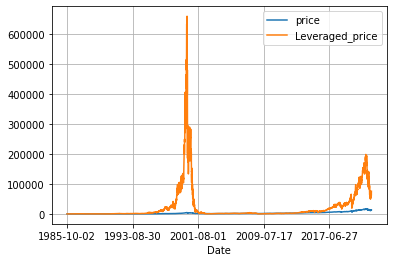

In [9]:
data1.plot(x ='Date', y=[
    'price', 
    'Leveraged_price',
    ], grid = True)

tqqq vs 3x qqq

In [10]:
data_3x  = pd.read_csv(
    etf_3x_csv,
    )

In [11]:
compare_3x = pysqldf(u"""
    select 
    data1.Date,
    data1.`Leveraged_price`,
    data_3x.Close
    from data_3x
    join data1 on data1.Date = data_3x.Date
    order by data1.Date asc
    """.format(leverage_ratio))

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [13]:
X = compare_3x['Leveraged_price'].to_numpy()
X = np.array([[i] for i in X])
y = compare_3x['Close'].to_numpy()

In [14]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

In [15]:
reg.score(X, y)

print(reg.coef_)

print(reg.intercept_)

[0.00044843]
0.0


In [16]:
result = pysqldf(u"""
    select 
    Date,
    `Leveraged_price` * {} + {} AS simulated_Close,
    Close
    from compare_3x
    """.format(
    reg.coef_[0],
    reg.intercept_))

<AxesSubplot:xlabel='Date'>

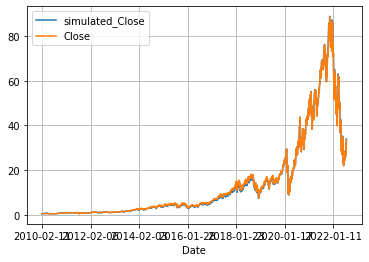

In [17]:
result.plot(x ='Date', y=[
    'simulated_Close', 
    'Close',
    ], grid = True)

all simulation results

In [18]:
final_result = pysqldf(u"""
    select 
    data1.Date,
    data1.price AS {},
    data1.`Leveraged_price` * {} + {} AS simulated_{},
    data_3x.Close as {}
    from data1
    left join data_3x on data_3x.Date = data1.Date
    """.format(
    ETF,
    reg.coef_[0],
    reg.intercept_,
    ETF_3x,
    ETF_3x
    ))

In [19]:
final_result.to_excel(
    simulation_result_xlsx,
    index = False,
    )

END